# Sequential&Module
之前用过module来构建模型，但不是特别理解里面参数的含义，这次来学习一下pytorch中module和sequential的含义到底是什么。

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

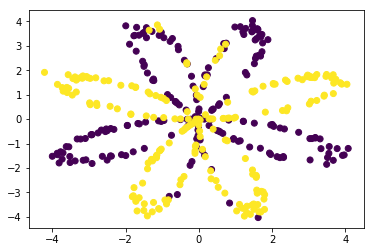

In [16]:
#generate data
np.random.seed(1)
m = 400 # 样本数量
N = int(m/2) # 每一类的点的个数
D = 2 # 维度
x = np.zeros((m, D))
y = np.zeros((m, 1), dtype='uint8') # label 向量，0 表示红色，1 表示蓝色
a = 4

for j in range(2):
    ix = range(N*j,N*(j+1))
    t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
    x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
plt.scatter(x[:,0],x[:,1],c=y.reshape(-1))
x=torch.from_numpy(x).float()
y=torch.from_numpy(y).float()

In [17]:
seq_net=nn.Sequential(
    nn.Linear(2,4),
    nn.Tanh(),
    nn.Linear(4,1)#两层神经网络
)

In [18]:
#第一层
seq_net[0]

Linear(in_features=2, out_features=4, bias=True)

bias是阈值，相当于取得1或0的难易程度

In [19]:
w0=seq_net[2].weight
print w0

Parameter containing:
 0.2850 -0.1114  0.1856 -0.0864
[torch.FloatTensor of size 1x4]



In [20]:
param=seq_net.parameters()
optim=torch.optim.SGD(param,1.)

In [22]:
criterion=nn.BCEWithLogitsLoss()
for e in range(10000):
    out=seq_net(Variable(x))
    loss=criterion(out,Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e+1)%1000==0:
        print('epoch:{},loss:{}'.format(e+1,loss.data[0]))

epoch:1000,loss:0.283451735973
epoch:2000,loss:0.271522969007
epoch:3000,loss:0.26463586092
epoch:4000,loss:0.259941935539
epoch:5000,loss:0.256586432457
epoch:6000,loss:0.254098147154
epoch:7000,loss:0.252193212509
epoch:8000,loss:0.250695317984
epoch:9000,loss:0.249490857124
epoch:10000,loss:0.2485037148


In [23]:
#保存模型
torch.save(seq_net,'two_layer.pth')

In [24]:
seq_net1=torch.load('two_layer.pth')

In [25]:
seq_net1[0]

Linear(in_features=2, out_features=4, bias=True)

In [27]:
#只保存参数
torch.save(seq_net.state_dict(),'two_layer_params.pth')
seq_net2=nn.Sequential(
    nn.Linear(2,4),
    nn.Tanh(),
    nn.Linear(4,1)
)
seq_net2.load_state_dict(torch.load('two_layer_params.pth'))

In [29]:
w0=seq_net2[2].weight
print(w0)

Parameter containing:
 10.7572  -6.0413  -0.6793   6.1442
[torch.FloatTensor of size 1x4]



只保留参数的方法可移植性更强。

定义module的模板

`
class 网络名字(nn.Module):
    def __init__(self,一些参数):
        super(网络名字,self).__init__()
        self.layer1=nn.Linear(inputlayer,outputlayer)
        self.layer2=nn.Sequential(...)
        ...
    前向传播函数
    def forward():
        x1=self.layer1(x)
        x2=self.layer2(x)
        x=x1+x2
        return x
`

In [37]:
#将上面的二层网络定义成module
class two_layer(nn.Module):
    def __init__(self,inputlayer,hiddenlayer,outputlayer):
        super(two_layer,self).__init__()
        self.layer1=nn.Linear(inputlayer,hiddenlayer)
        self.layer2=nn.Tanh()
        self.layer3=nn.Linear(hiddenlayer,outputlayer)
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        return x

In [38]:
net=two_layer(2,4,1)

In [39]:
l1=net.layer1
print(l1)

Linear(in_features=2, out_features=4, bias=True)


In [40]:
print l1.weight

Parameter containing:
-0.4068 -0.4052
 0.5113  0.6490
-0.5871 -0.4607
-0.1086  0.2917
[torch.FloatTensor of size 4x2]



In [41]:
optim=torch.optim.SGD(net.parameters(),1.)

关于optimizer的含义和理解，参考[link](https://blog.csdn.net/sunny_580/article/details/75387784)

In [42]:
for e in range(10000):
    out=net(Variable(x))
    loss=criterion(out,Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e+1)%10000==0:
        print('epoch:{},loss:{}'.format(e+1,loss.data[0]))

epoch:10000,loss:0.24852232635


下面定义一个更深层网络，获取结果。

In [52]:
class deeper_net(nn.Module):
    def __init__(self,inputlayer,hiddenlayer,outputlayer):
        super(deeper_net,self).__init__()
        self.layer1=nn.Linear(inputlayer,hiddenlayer)
        self.layer2=nn.Tanh()
        self.layer3=nn.Linear(hiddenlayer,hiddenlayer)
        self.layer4=nn.Tanh()
        self.layer5=nn.Linear(hiddenlayer,hiddenlayer)
        self.layer6=nn.Tanh()
        self.layer7=nn.Linear(hiddenlayer,outputlayer)
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)
        x=self.layer6(x)
        x=self.layer7(x)
        return x
dep=deeper_net(2,10,1)
optim=torch.optim.SGD(dep.parameters(),0.01)

In [53]:
for epoch in range(10000):
    out=dep(Variable(x))
    loss=criterion(out,Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (epoch+1)%2000==0:
        print('epoch:{},loss:{}'.format(epoch+1,loss.data[0]))

epoch:2000,loss:0.601010262966
epoch:4000,loss:0.359057247639
epoch:6000,loss:0.329297035933
epoch:8000,loss:0.304685294628
epoch:10000,loss:0.277664899826


网络变深，loss小了

Text(0.5,1,'deeper_model')

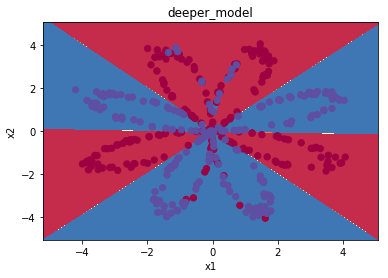

In [51]:
def plot_net(x):
    out=F.sigmoid(dep(Variable(torch.from_numpy(x).float()))).data.numpy()
    out=(out>0.5)*1
    return out
def plot_decision_boundary(model, x, y):
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=40, cmap=plt.cm.Spectral)
plot_decision_boundary(lambda x: plot_net(x), x.numpy(), y.numpy())
plt.title('deeper_model')

layer5虽然loss小了，但图上好像没什么区别，再加深一点试试。试着把学习率降低到0.01，发现loss反而增加,不如学习率为0.1的时候，应该是陷入了局部最优。